In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")

In [3]:
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [4]:
print(train.shape)
print(test.shape)

(2896, 34)
(1008, 33)


# EDA Function

In [5]:
def read_file(filename):
    df = pd.read_csv(f'{filename}')
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

def get_values(data, code, col):
    df = data[(data['단지코드']==code)&(data[col].isna()==False)]
    return df[col].values.mean()

def impute_by_code(data, col, verbose=True):
    code = data[data[col].isna()==True]['단지코드'].unique()
    if verbose == True:
        print(f"{col}에 NA가 있는 단지코드: {code}")
        print(f"{col}이(가) 모두 NA인 단지코드:")
    for i in code:
        n = data[(data['단지코드']==i)&(data[col].isna()==False)].shape[0]
        ind = data[(data['단지코드']==i)&(data[col].isna()==True)].index
        if n != 0 :
            data.loc[ind,col] = get_values(data, i, col)
        if n==0 and verbose == True:
            print(i)
    return data    

def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

def make_dummies(data, col):
    sample = pd.DataFrame(data.groupby('단지코드')[col].unique()).reset_index()
    for i in dic.keys():
        data[col.split('_')[0]+str(i)]=0
    for i in sample.index:
        code = sample.loc[i,'단지코드']
        val = sample.loc[i,col]
        ind = data[data['단지코드']==code].index
        for j in val:
            data.loc[ind,col.split('_')[0]+str(j)] = 1
    return data

def dual_countplot(col, train, test, figsize=(14,8), pallete="Set2", flip=True):
    plt.rcParams["figure.figsize"] = figsize
    fig, ax = plt.subplots(ncols=2)
    if flip:
        sns.countplot(y=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(y=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    else:
        sns.countplot(x=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(x=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    plt.tight_layout()
    plt.show()
    
def get_outlier(df=None, column=None, weight=1.5):

    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    
    return outlier_idx

# EDA

In [6]:
train['등록차량수/총세대수'] = train.apply(lambda x : x['등록차량수']/x['총세대수'], axis=1)
train['등록차량수/단지내주차면수'] = train.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)

In [7]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율',
       '등록차량수/총세대수', '등록차량수/단지내주차면수'],
      dtype='object')

## 자격유형

In [8]:
print('자격유형 개수 : ',train['자격유형'].nunique())

자격유형 개수 :  15


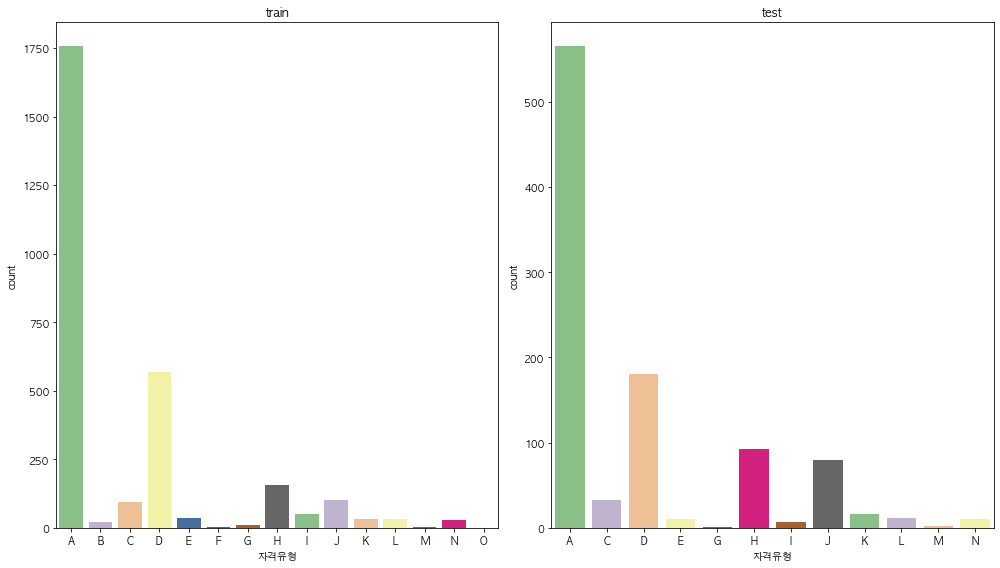

In [9]:
dual_countplot(col="자격유형", train=train, test=test, flip=False, pallete="Accent")

In [10]:
tmp = train.copy()

In [11]:
outlier_idx1 = get_outlier(train,'임대보증금')
tmp = train.drop(outlier_idx1,axis=0)
outlier_idx2 = get_outlier(tmp,'임대료')
tmp = tmp.drop(outlier_idx2,axis=0)
outlier_idx3 = get_outlier(tmp,'등록차량수')
tmp = tmp.drop(outlier_idx3,axis=0)

<AxesSubplot:title={'center':'임대보증금/임대료'}, xlabel='[자격유형]'>

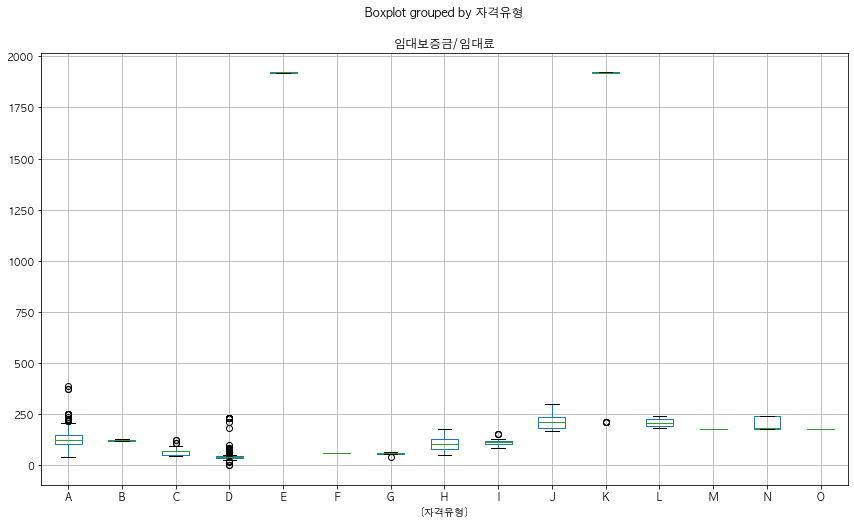

In [12]:
tmp['임대보증금/임대료'] = tmp.apply(lambda x : x['임대보증금']/x['임대료'],axis=1)
tmp.boxplot(column=['임대보증금/임대료'],by=['자격유형'])

- E와 K는 하나의 그룹으로 보자

<AxesSubplot:title={'center':'임대보증금/임대료'}, xlabel='[자격유형]'>

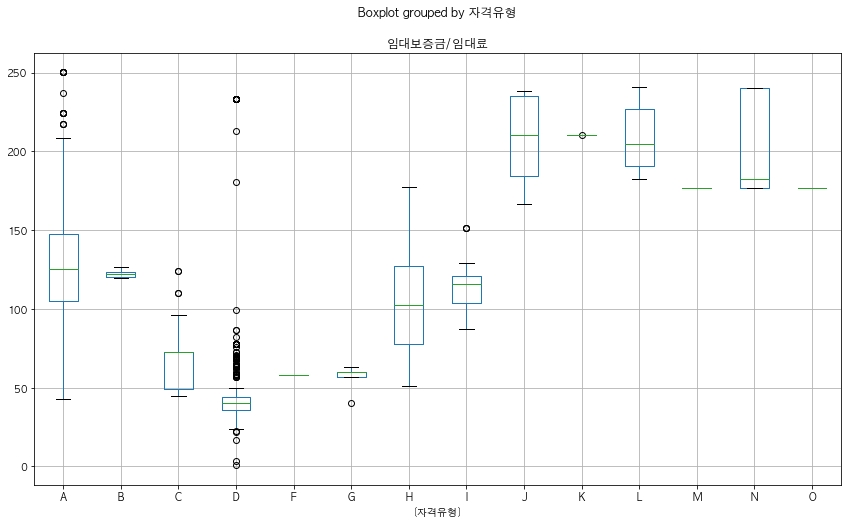

In [13]:
outlier_idx2 = get_outlier(tmp,'임대보증금/임대료')
tmp = tmp.drop(outlier_idx2,axis=0)
tmp.boxplot(column=['임대보증금/임대료'],by=['자격유형'])

- A : 가장 넓은 범위
- D : 상가건물
- E K : 임대료에 비해 임대보증금이 많이 큰 경우
- J L M N O : 임대료 < 임대보증금
- B H I G: 임대보증금/임대료 중간정도
- C F : 임대료 > 임대보증금

- 임대보증금/임대료 변수와 등록차량수/총세대수 변수를 비교했을 때 가장 유의미하게 그룹핑이 가능하다

<AxesSubplot:title={'center':'등록차량수/총세대수'}, xlabel='[자격유형]'>

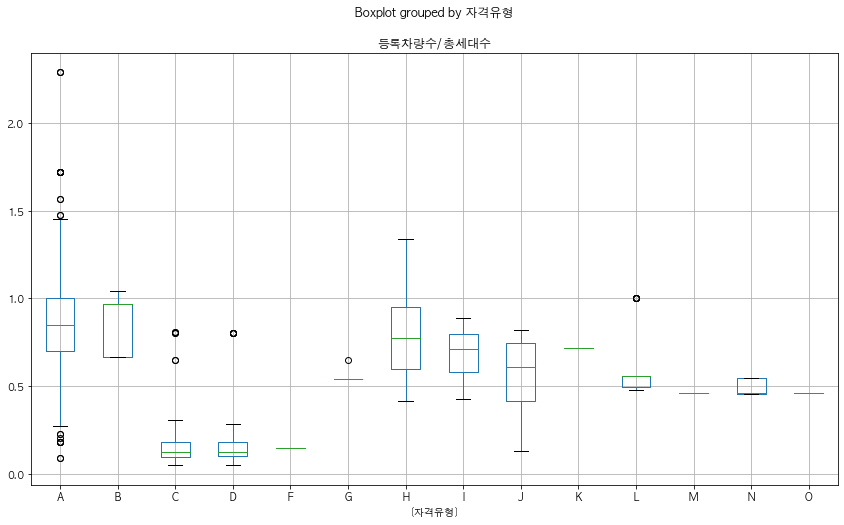

In [14]:
tmp.boxplot(column=['등록차량수/총세대수'],by=['자격유형'])

<AxesSubplot:title={'center':'등록차량수/단지내주차면수'}, xlabel='[자격유형]'>

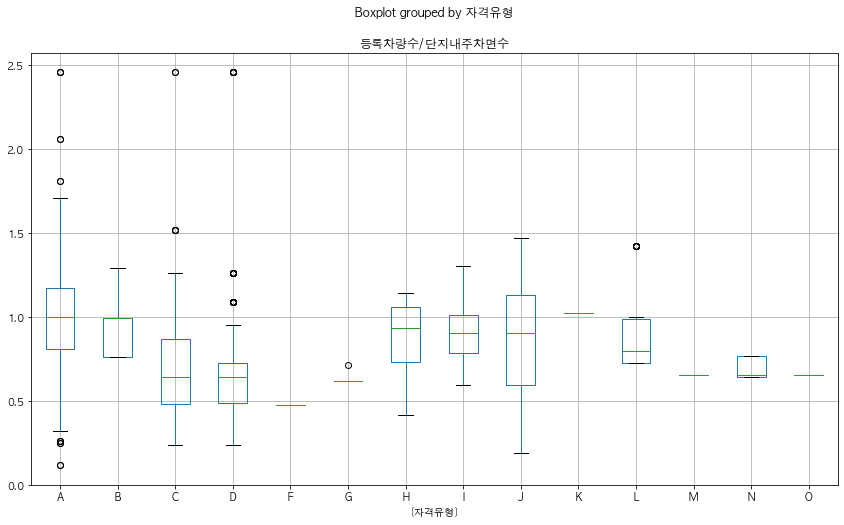

In [15]:
tmp.boxplot(column=['등록차량수/단지내주차면수'],by=['자격유형'])

<AxesSubplot:title={'center':'등록차량수'}, xlabel='[자격유형]'>

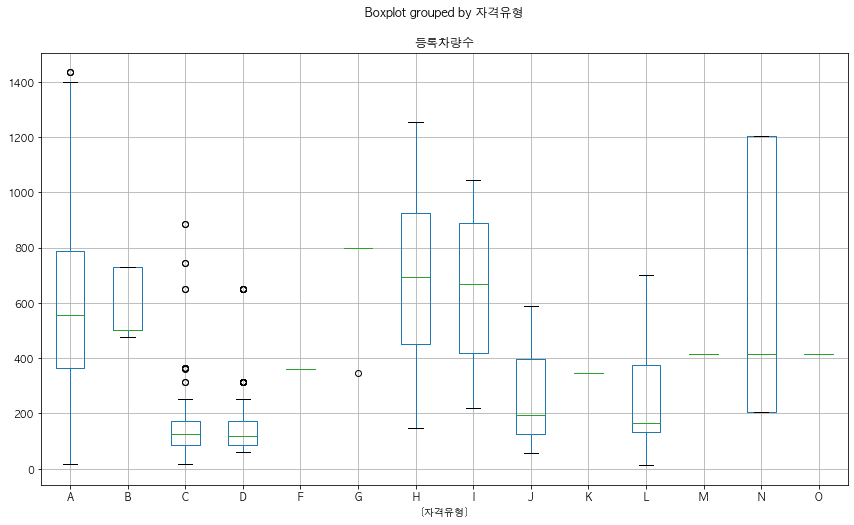

In [16]:
tmp.boxplot(column=['등록차량수'],by=['자격유형'])

In [17]:
tmp = train[train['자격유형']=='K']
tmp['임대보증금/임대료'] = tmp.apply(lambda x : x['임대보증금']/x['임대료'],axis=1)
print(np.array(tmp['임대보증금/임대료']))
#plt.scatter(x=tmp['임대보증금/임대료'],y=tmp['등록차량수/총세대수'])

[1921.02272727 1921.02272727 1921.02272727 1921.02272727 1921.02272727
  210.52547516  210.53945512  210.53213545  210.53213545 1920.87973274
 1920.         1920.28051554 1920.28051554 1920.28051554 1920.
 1920.         1920.         1920.16412661 1920.         1920.21433851
 1920.21433851 1920.21433851 1920.15936255 1920.15936255 1920.15936255
 1920.04474273 1920.04474273 1919.98865892 1919.98865892 1920.43998886
 1919.98865892 1920.46218487 1920.46218487]


In [18]:
tmp = test[test['자격유형']=='K']
tmp['임대보증금/임대료'] = tmp.apply(lambda x : x['임대보증금']/x['임대료'],axis=1)
print(np.array(tmp['임대보증금/임대료']))

[1919.97703789 1919.97703789 1920.14613779 1920.14613779 1920.14613779
 1920.14613779 1920.51106548 1920.51106548 1920.51106548 1920.51106548
 1920.65275548 1920.03994674 1920.56546617 1920.56546617 1919.98556999
 1919.98556999]


- test 데이터를 살펴보았을 때 K 자격유형에 대한 임대보증금/임대료 비율이 1900대 이다. 250이하의 값은 outlier로 봐야할 듯

## 지하철역 

In [19]:
No_sub = [i for i in train['지역'].unique() if all(train[train['지역']==i]['지하철역'].unique() == [0])]
sub = np.array(list(set(train['지역'])-set(No_sub)))
print('지하철역 없는 지역 : ',No_sub)
print('지하철역 있는 지역 : ',sub)

지하철역 없는 지역 :  ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
지하철역 있는 지역 :  ['경기도' '서울특별시' '대구광역시' '부산광역시' '대전광역시']


<AxesSubplot:xlabel='subway_dist', ylabel='Density'>

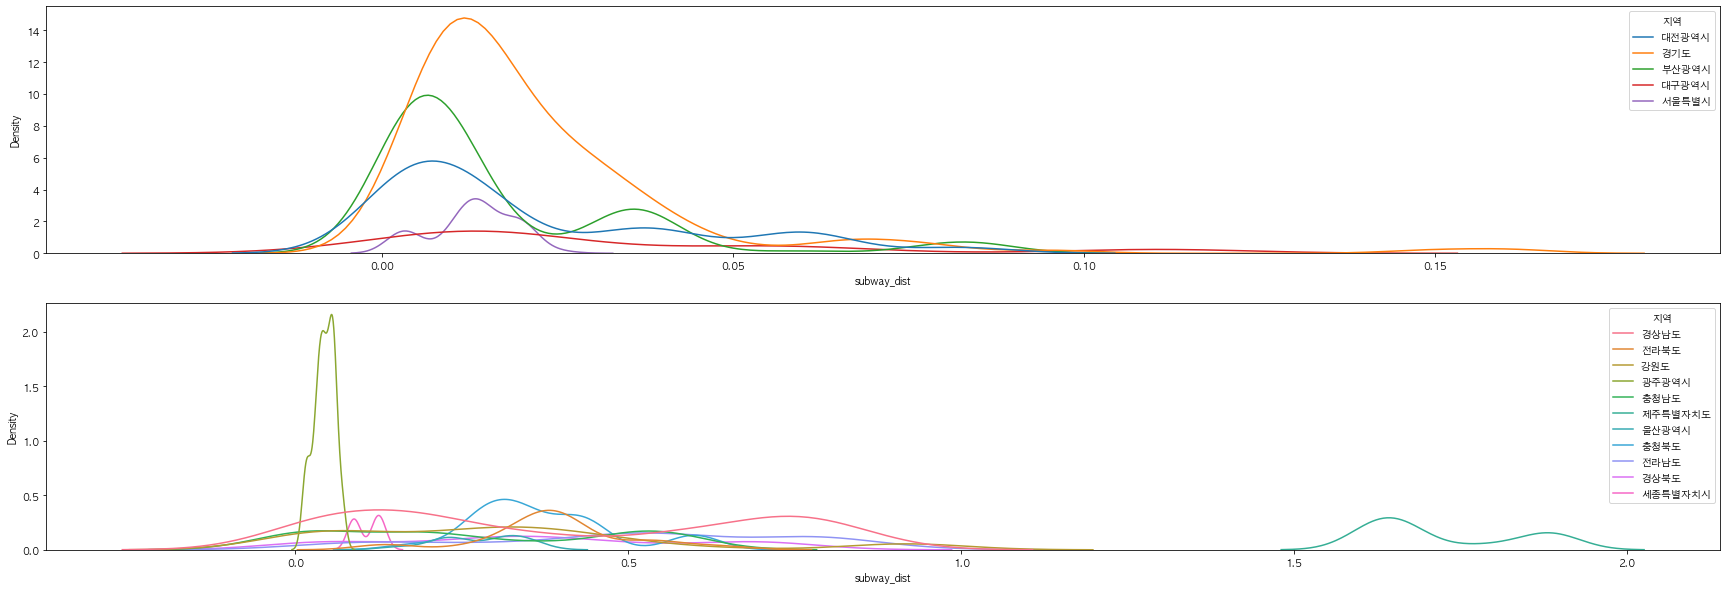

In [20]:
tmp = train.loc[train['지역'].isin(sub),:]
tmp1 = train.loc[train['지역'].isin(No_sub),:]
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.kdeplot(data=tmp,x='subway_dist',color='black',hue='지역',ax=ax[0])
sns.kdeplot(data=tmp1,x='subway_dist',color='black',hue='지역',ax=ax[1])

<AxesSubplot:xlabel='subway_dist', ylabel='등록차량수'>

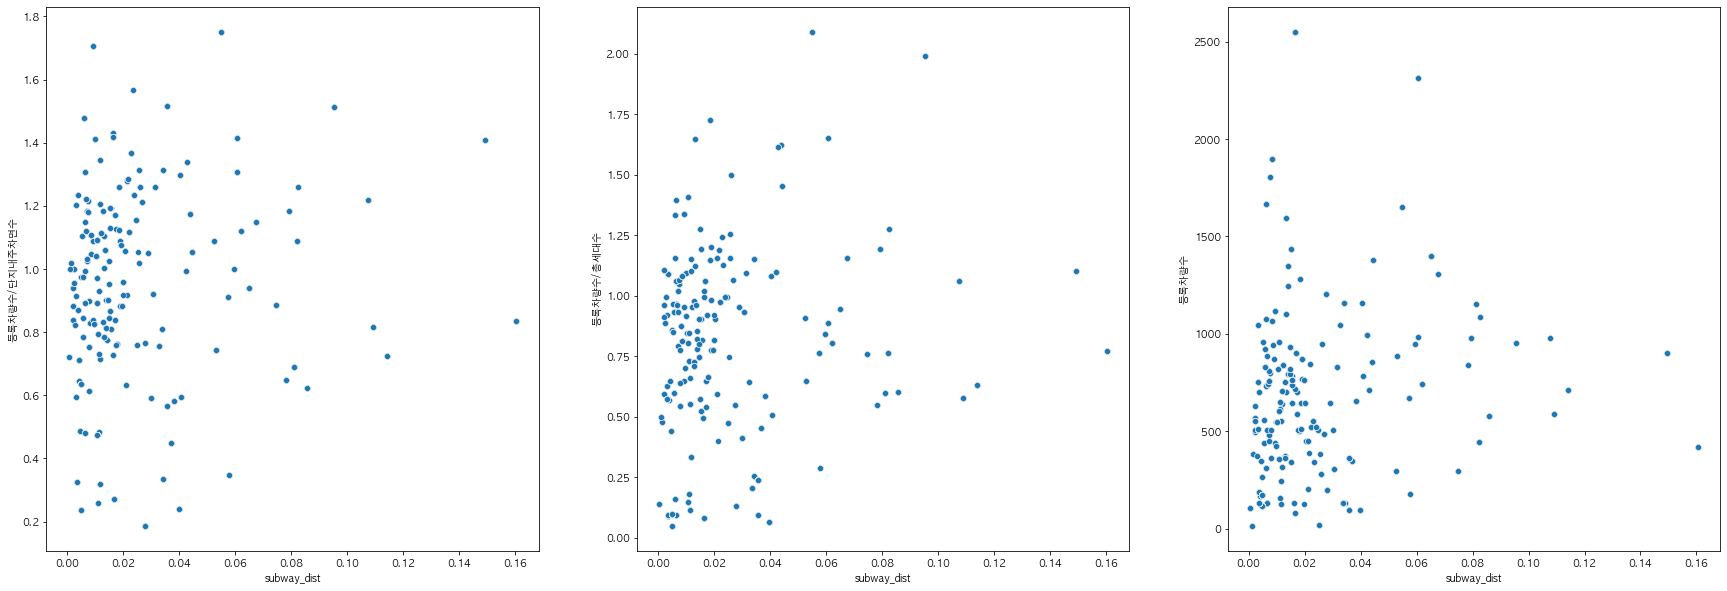

In [21]:
outlier_idx = get_outlier(tmp,'등록차량수/총세대수')
tmp = tmp.drop(outlier_idx,axis=0)
fig, ax = plt.subplots(1,3,figsize=(30,10))
sns.scatterplot(x=tmp['subway_dist'],y=tmp['등록차량수/단지내주차면수'],ax=ax[0])
sns.scatterplot(x=tmp['subway_dist'],y=tmp['등록차량수/총세대수'],ax=ax[1])
sns.scatterplot(x=tmp['subway_dist'],y=tmp['등록차량수'],ax=ax[2])

<AxesSubplot:title={'center':'등록차량수'}, xlabel='[환승역 수]'>

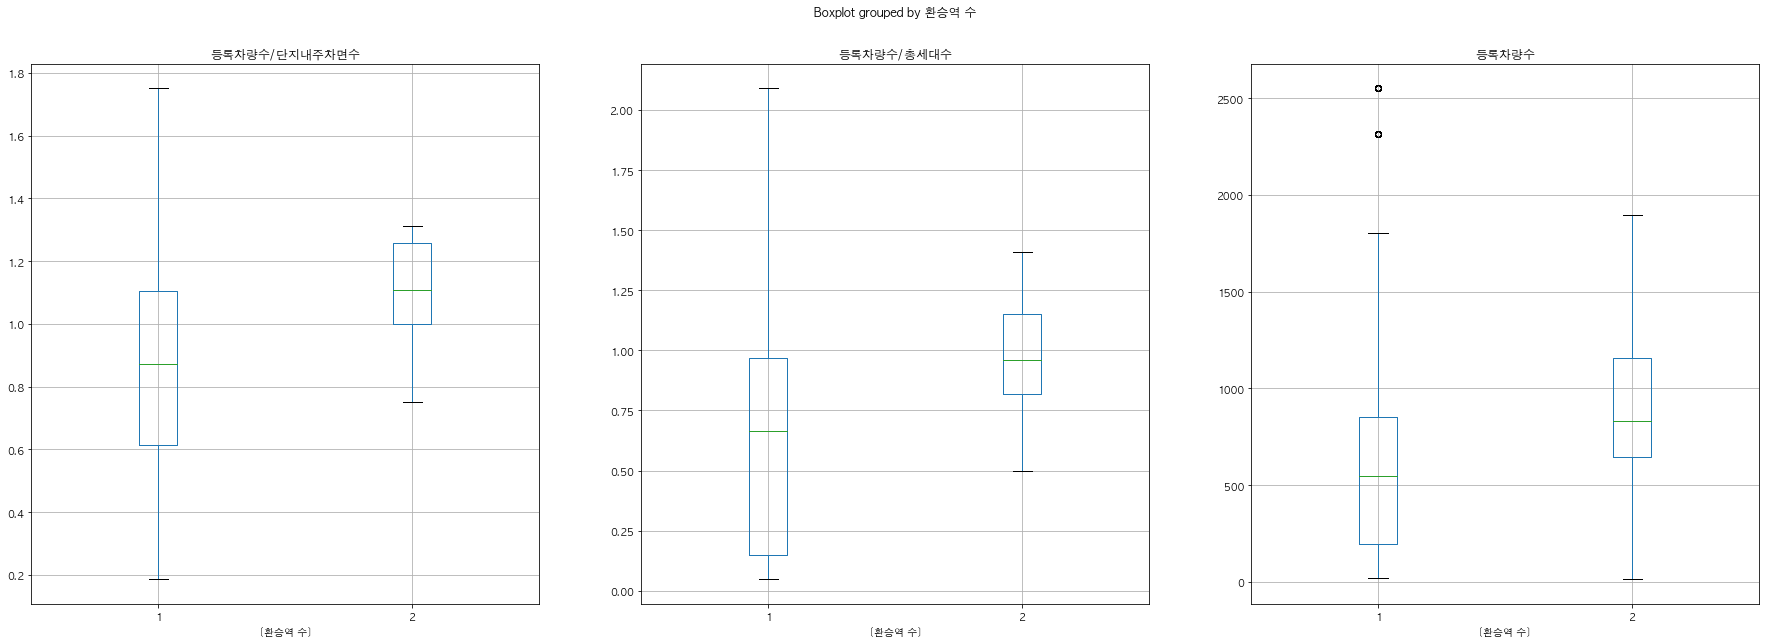

In [22]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
tmp.boxplot(column=['등록차량수/단지내주차면수'],by=['환승역 수'],ax=ax[0])
tmp.boxplot(column=['등록차량수/총세대수'],by=['환승역 수'],ax=ax[1])
tmp.boxplot(column=['등록차량수'],by=['환승역 수'],ax=ax[2])

<AxesSubplot:xlabel='subway_dist', ylabel='등록차량수'>

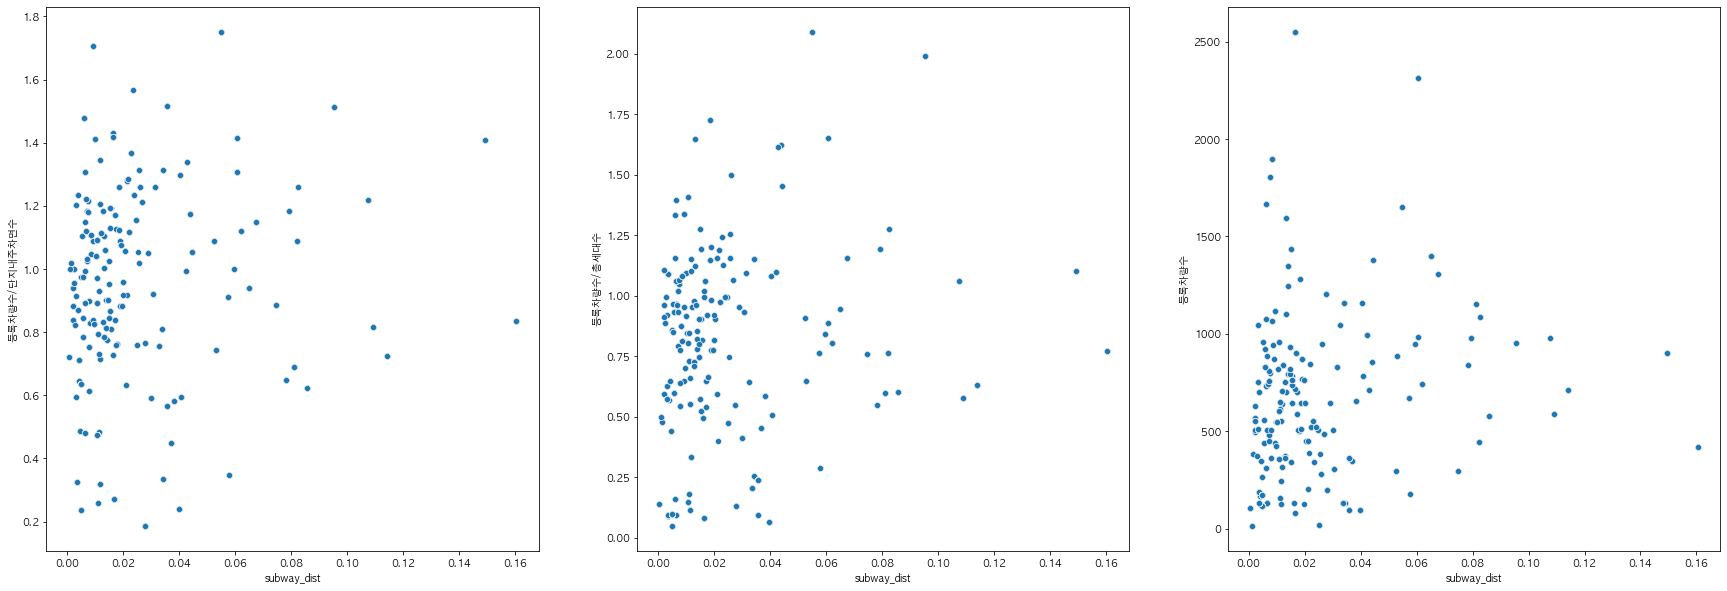

In [23]:
outlier_idx = get_outlier(tmp1,'등록차량수/총세대수')
tmp1 = tmp1.drop(outlier_idx,axis=0)
fig, ax = plt.subplots(1,3,figsize=(30,10))
sns.scatterplot(x=tmp['subway_dist'],y=tmp['등록차량수/단지내주차면수'],ax=ax[0])
sns.scatterplot(x=tmp['subway_dist'],y=tmp['등록차량수/총세대수'],ax=ax[1])
sns.scatterplot(x=tmp['subway_dist'],y=tmp['등록차량수'],ax=ax[2])

<AxesSubplot:title={'center':'등록차량수'}, xlabel='[환승역 수]'>

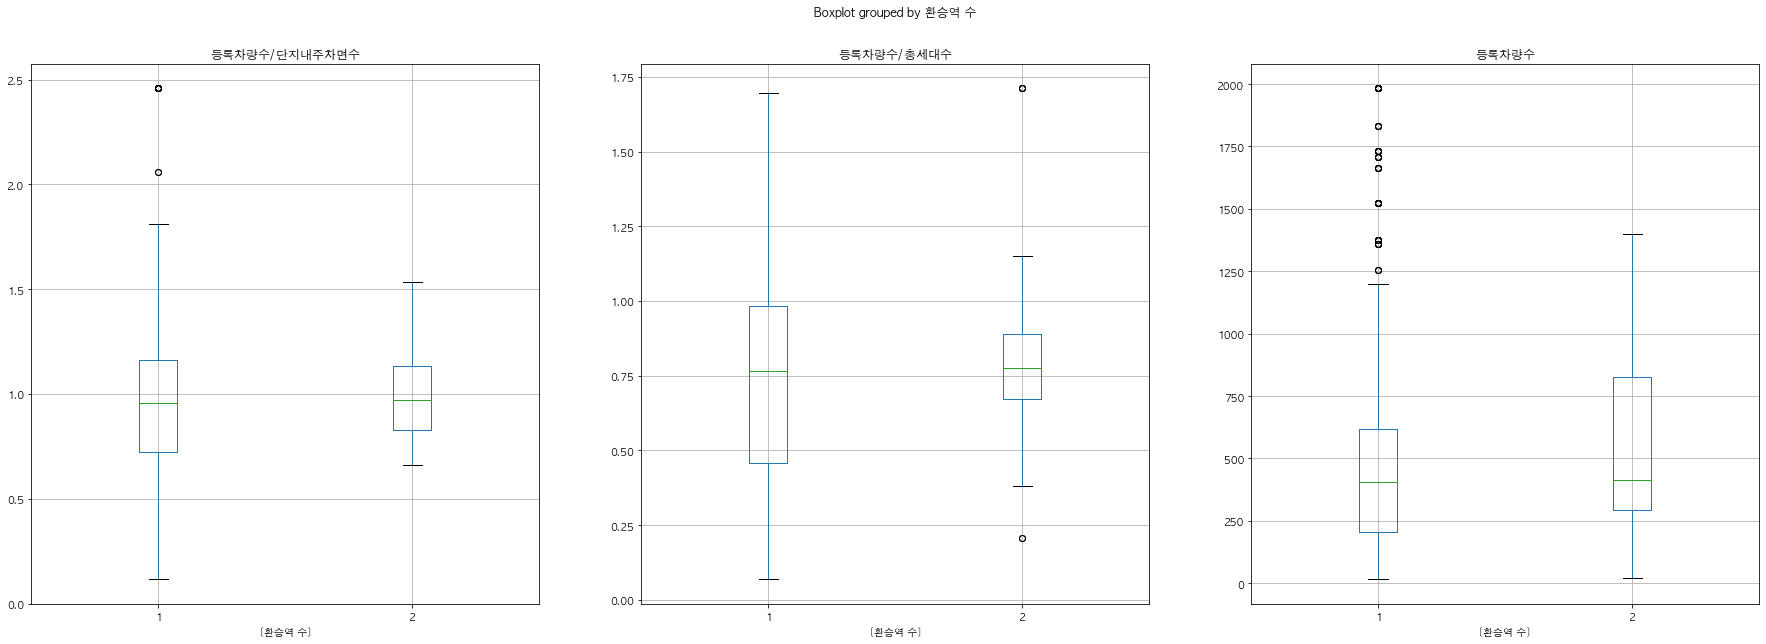

In [24]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
tmp1.boxplot(column=['등록차량수/단지내주차면수'],by=['환승역 수'],ax=ax[0])
tmp1.boxplot(column=['등록차량수/총세대수'],by=['환승역 수'],ax=ax[1])
tmp1.boxplot(column=['등록차량수'],by=['환승역 수'],ax=ax[2])

In [25]:
print(tmp.shape)
print(tmp1.shape)

(1356, 36)
(1524, 36)


- 지하철역까지의 거리는 무의미한 변수 $\rightarrow$ 제거하자
- 환승역의 개수는 10분 내에 지하철역이 존재하는 지역인 '대전광역시' '대구광역시' '경기도' '부산광역시' '서울특별시'에서만 유의미한 변수로 적용되었다
- sub, No_sub로 나눠서 모델링 하는 것?

In [26]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율',
       '등록차량수/총세대수', '등록차량수/단지내주차면수'],
      dtype='object')

## 버스정류장

<AxesSubplot:xlabel='버스정류장', ylabel='Count'>

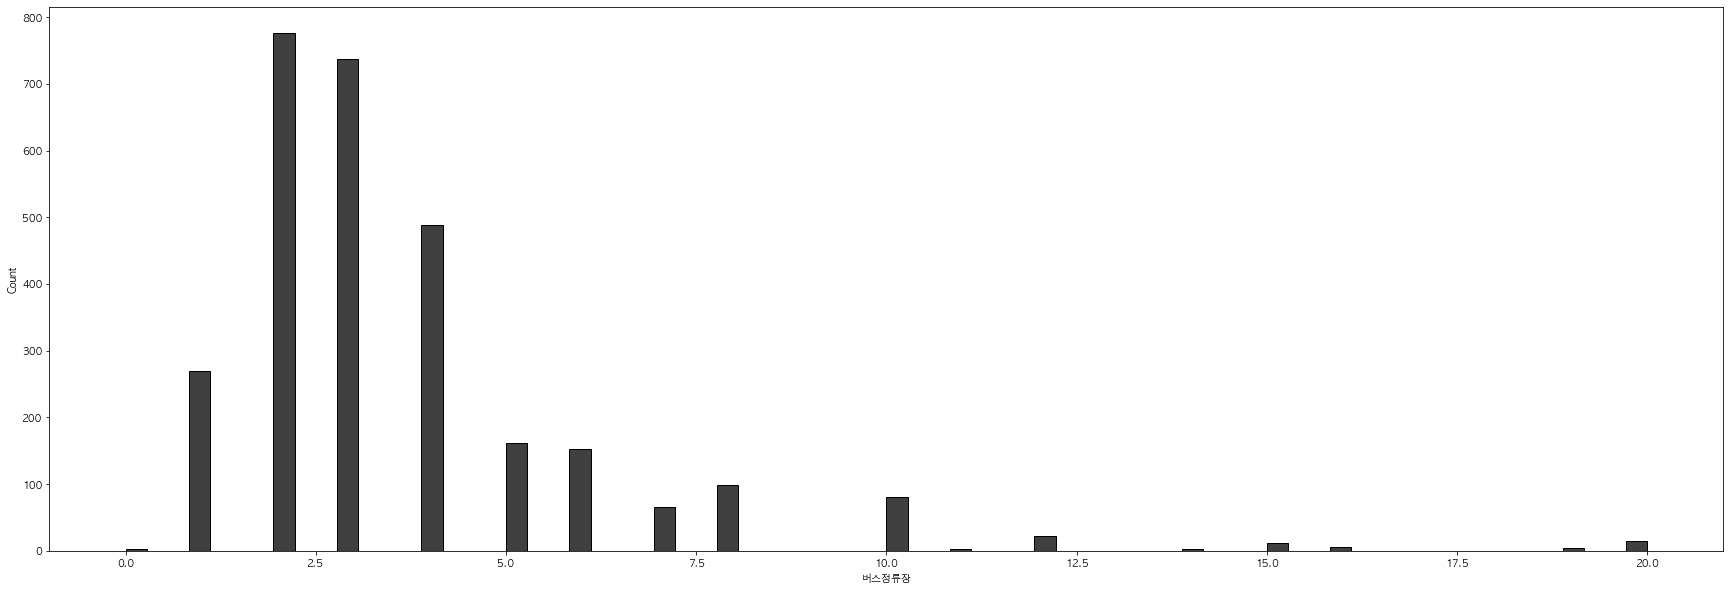

In [27]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=train,x='버스정류장',color='black')

## 전용면적

- 두 그룹(sub,no_sub) 간의 분포 차이가 없다 $\rightarrow$ train 기준으로 1차원 merge하자

<AxesSubplot:xlabel='전용면적', ylabel='Count'>

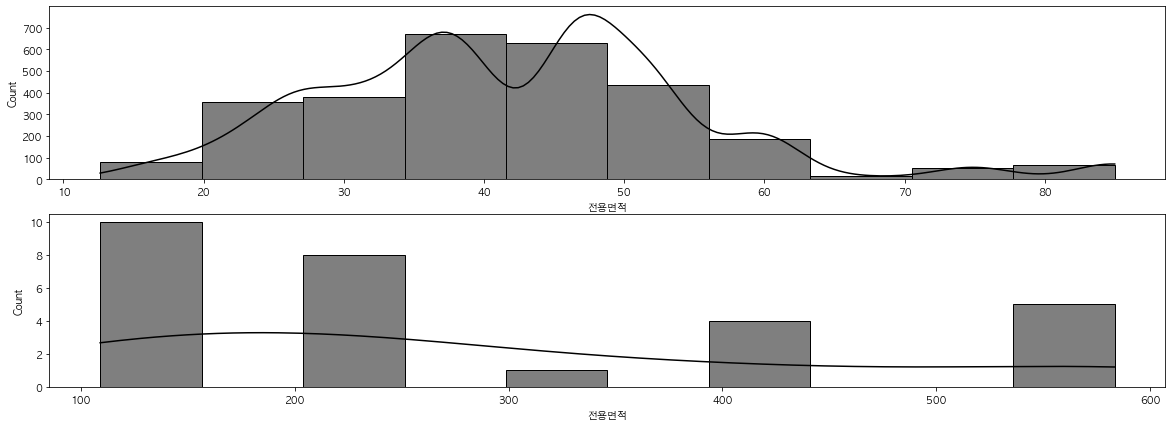

In [28]:
fig,ax = plt.subplots(2,1,figsize=(20,7))
sns.histplot(data=train[train['전용면적']<100], x='전용면적',color='black',kde=True,bins=10,ax=ax[0])
sns.histplot(data=train[train['전용면적']>100], x='전용면적',color='black',kde=True,bins=10,ax=ax[1])

In [29]:
area = pd.DataFrame(tmp.groupby('단지코드').count()['전용면적']).reset_index()
area1 = pd.DataFrame(tmp1.groupby('단지코드').count()['전용면적']).reset_index()

<AxesSubplot:xlabel='전용면적', ylabel='Count'>

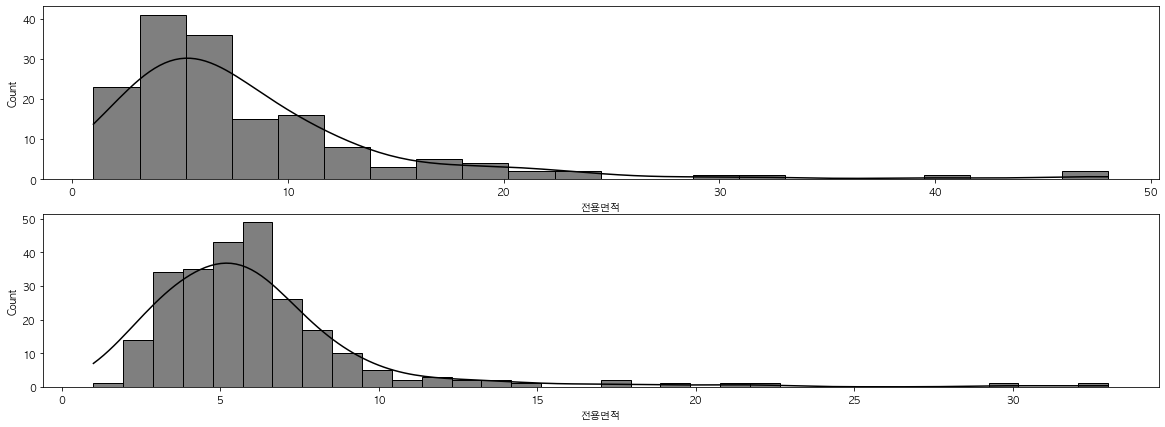

In [30]:
fig,ax = plt.subplots(2,1,figsize=(20,7))
sns.histplot(data=area, x='전용면적',color='black',kde=True,ax=ax[0])
sns.histplot(data=area1, x='전용면적',color='black',kde=True,ax=ax[1])

## 임대료/임대보증금

<AxesSubplot:xlabel='임대료', ylabel='Density'>

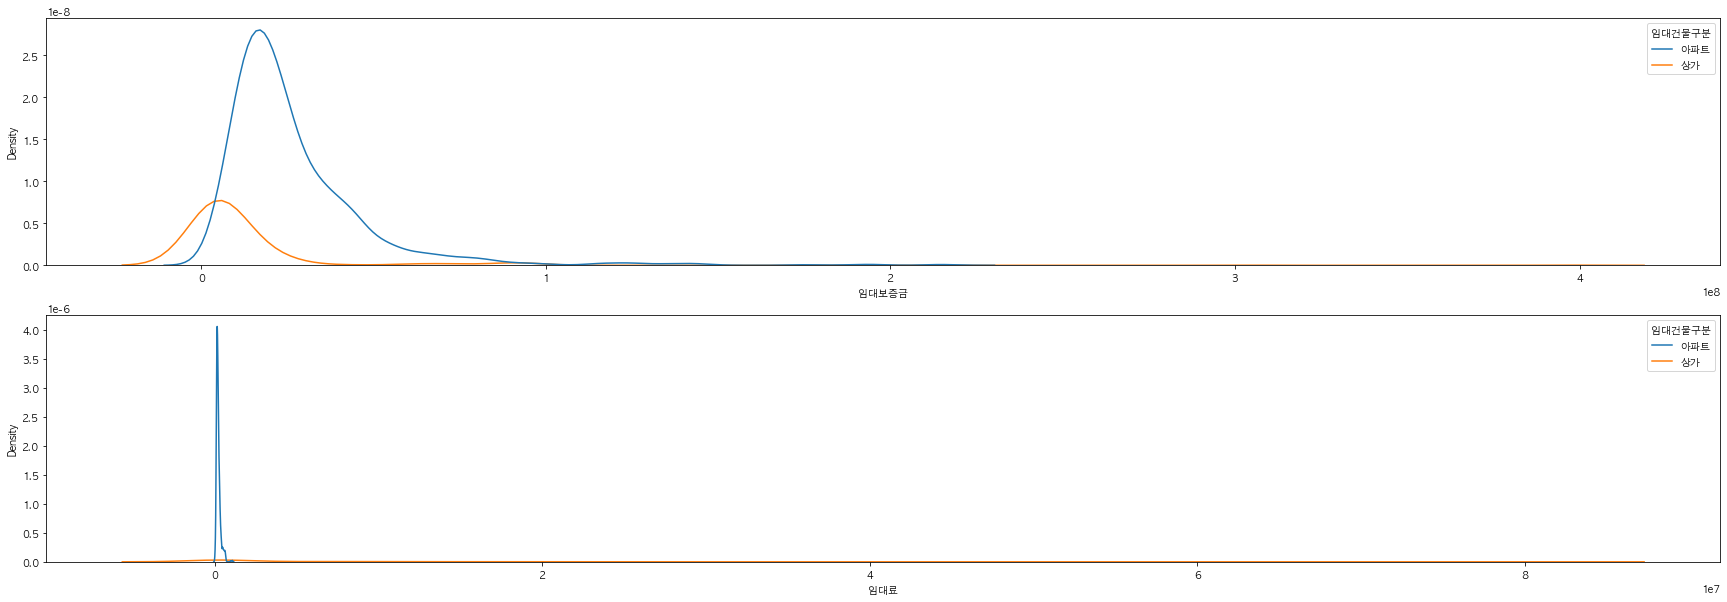

In [31]:
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.kdeplot(data=train,x='임대보증금',hue='임대건물구분',ax=ax[0])
sns.kdeplot(data=train,x='임대료',hue='임대건물구분',ax=ax[1])

In [32]:
apt = train[train['임대건물구분']=='아파트']
store = train[train['임대건물구분']=='상가']

### quantile 기준
#### 아파트

In [33]:
#아파트
price0 = apt.groupby('단지코드').describe()['임대료'].reset_index()
price1 = apt.groupby('단지코드').describe()['임대보증금'].reset_index()

tmp = apt.loc[apt['지역'].isin(sub),:]
tmp_price0 = tmp.groupby('단지코드').describe()['임대료']
tmp_price1 = tmp.groupby('단지코드').describe()['임대보증금']

tmp1 = apt.loc[apt['지역'].isin(No_sub),:]
tmp1_price0 = tmp1.groupby('단지코드').describe()['임대료']
tmp1_price1 = tmp1.groupby('단지코드').describe()['임대보증금']

In [34]:
y = apt[['단지코드','등록차량수/단지내주차면수','등록차량수/총세대수','등록차량수']].drop_duplicates()
apart_price0 = pd.merge(price0,y,on='단지코드',how='inner') #임대료
apart_price1 = pd.merge(price1,y,on='단지코드',how='inner') #임대보증금

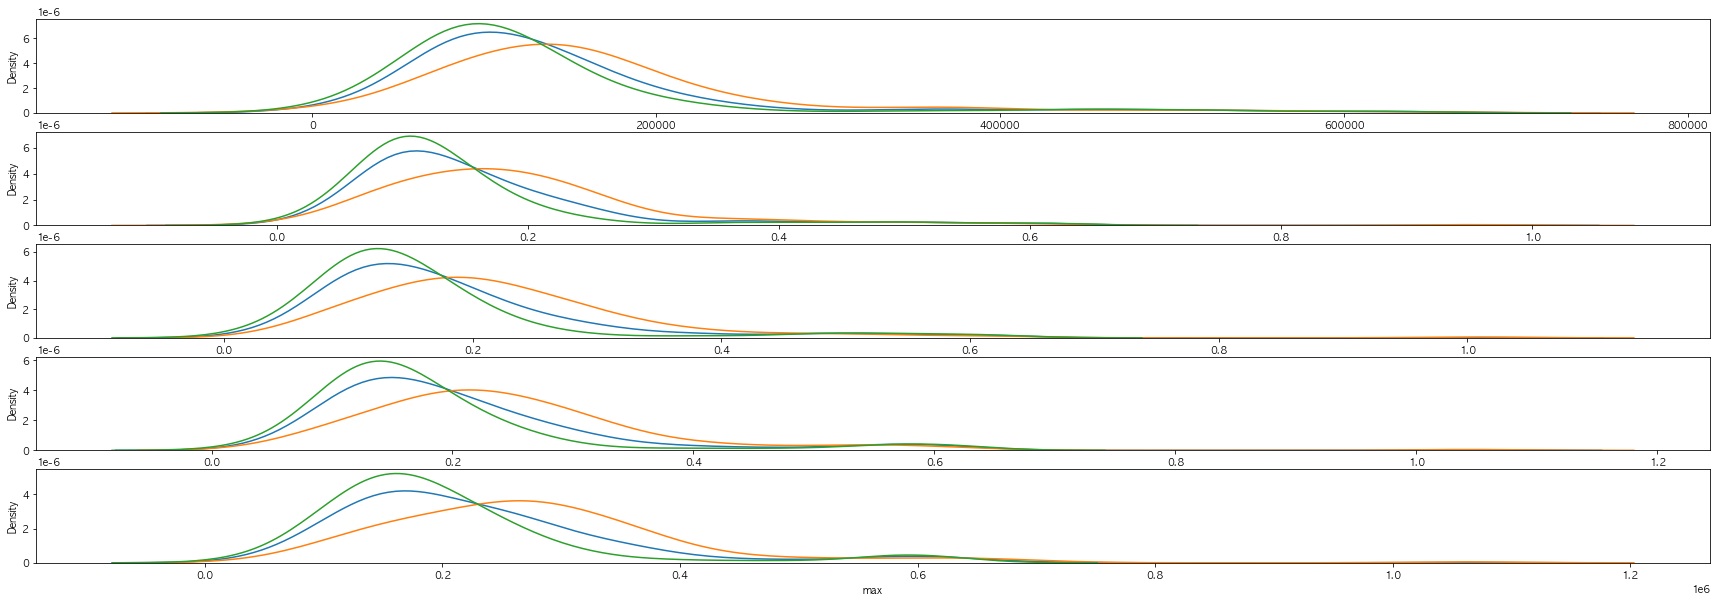

In [35]:
#아파트,임대료
fig, ax = plt.subplots(5,1,figsize=(30,10))
for ind,i in enumerate(['min','25%','50%','75%','max']):
    sns.kdeplot(data=price0,x=i,ax=ax[ind]) #전체 
    sns.kdeplot(data=tmp_price0,x=i,ax=ax[ind]) #sub
    sns.kdeplot(data=tmp1_price0,x=i,ax=ax[ind]) #no_sub

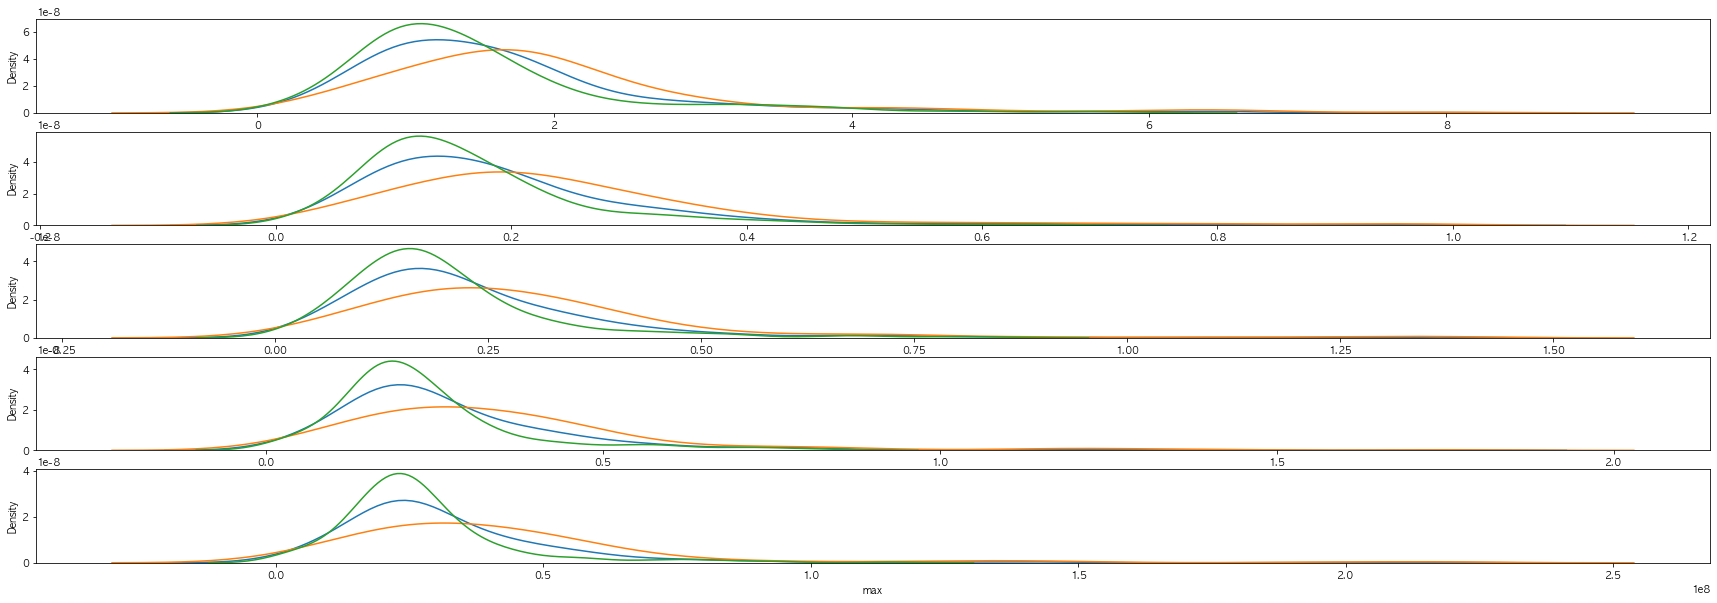

In [36]:
#아파트,임대보증금
fig, ax = plt.subplots(5,1,figsize=(30,10))
for ind,i in enumerate(['min','25%','50%','75%','max']):
    sns.kdeplot(data=price1,x=i,ax=ax[ind]) #전체 
    sns.kdeplot(data=tmp_price1,x=i,ax=ax[ind]) #sub
    sns.kdeplot(data=tmp1_price1,x=i,ax=ax[ind]) #no_sub

- blue 전체 / orange sub / green no_sub
- 아파트에서는 sub, no_sub로 나누는 것의 유의미

<AxesSubplot:xlabel='min', ylabel='등록차량수'>

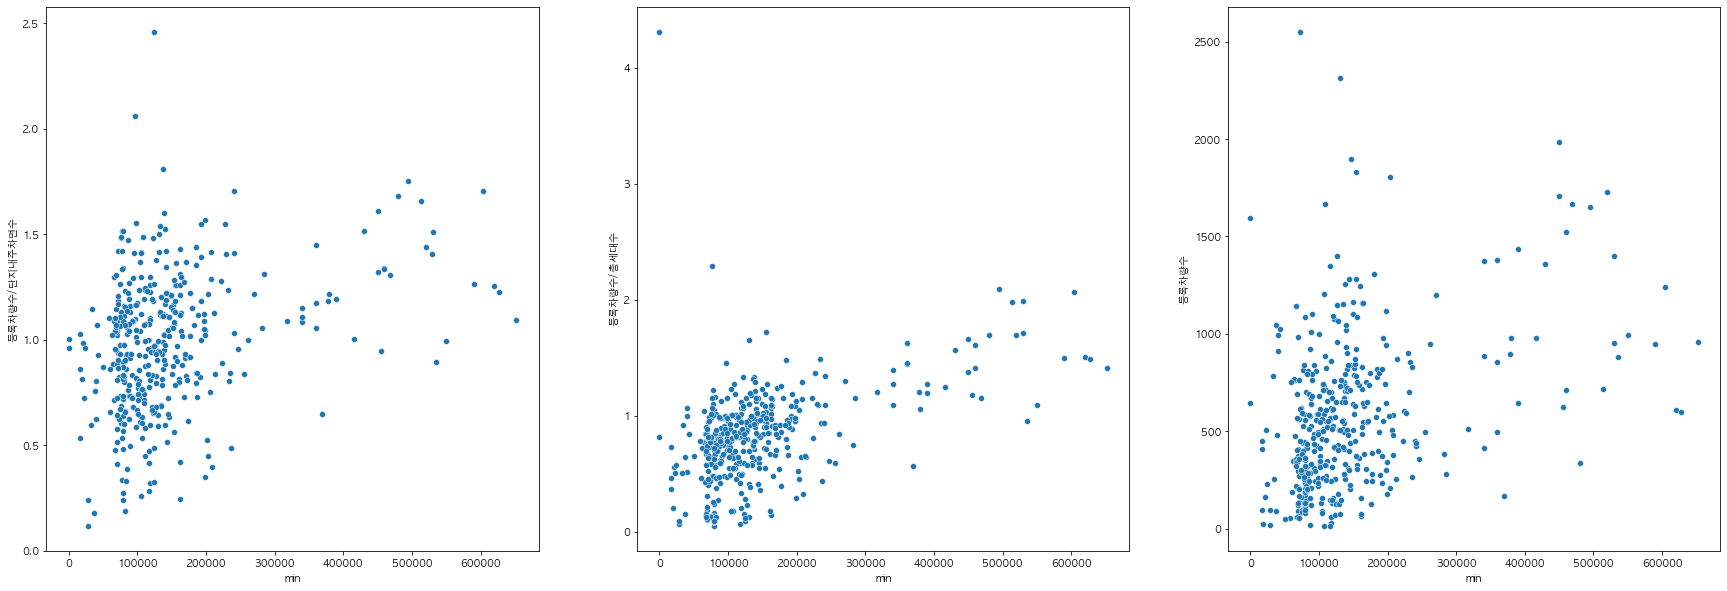

In [37]:
#임대료
fig, ax = plt.subplots(1,3,figsize=(30,10))

sns.scatterplot(x=apart_price0['min'],y=apart_price0['등록차량수/단지내주차면수'],ax=ax[0])
sns.scatterplot(x=apart_price0['min'],y=apart_price0['등록차량수/총세대수'],ax=ax[1])
sns.scatterplot(x=apart_price0['min'],y=apart_price0['등록차량수'],ax=ax[2])

In [38]:
apart_price0.corr()

,count,mean,std,min,25%,50%,75%,max,등록차량수/단지내주차면수,등록차량수/총세대수,등록차량수
count,1.0000,0.0918,0.3598,-0.0774,0.0216,0.1038,0.1528,0.2192,-0.0238,0.1432,0.4257
mean,0.0918,1.0000,0.3077,0.9455,0.9806,0.9921,0.9874,0.9548,0.3032,0.5387,0.4683
std,0.3598,0.3077,1.0000,0.0239,0.1504,0.3147,0.4137,0.5509,-0.0038,0.3148,0.3276
min,-0.0774,0.9455,0.0239,1.0000,0.9646,0.9254,0.8965,0.8323,0.3234,0.4866,0.3805
25%,0.0216,0.9806,0.1504,0.9646,1.0000,0.9699,0.9470,0.8892,0.3075,0.4850,0.4167
50%,0.1038,0.9921,0.3147,0.9254,0.9699,1.0000,0.9810,0.9454,0.2987,0.5407,0.4724
75%,0.1528,0.9874,0.4137,0.8965,0.9470,0.9810,1.0000,0.9679,0.2883,0.5379,0.4867
max,0.2192,0.9548,0.5509,0.8323,0.8892,0.9454,0.9679,1.0000,0.2687,0.5812,0.5202
등록차량수/단지내주차면수,-0.0238,0.3032,-0.0038,0.3234,0.3075,0.2987,0.2883,0.2687,1.0000,0.6904,0.3739
등록차량수/총세대수,0.1432,0.5387,0.3148,0.4866,0.4850,0.5407,0.5379,0.5812,0.6904,1.0000,0.5879


<AxesSubplot:xlabel='min', ylabel='등록차량수'>

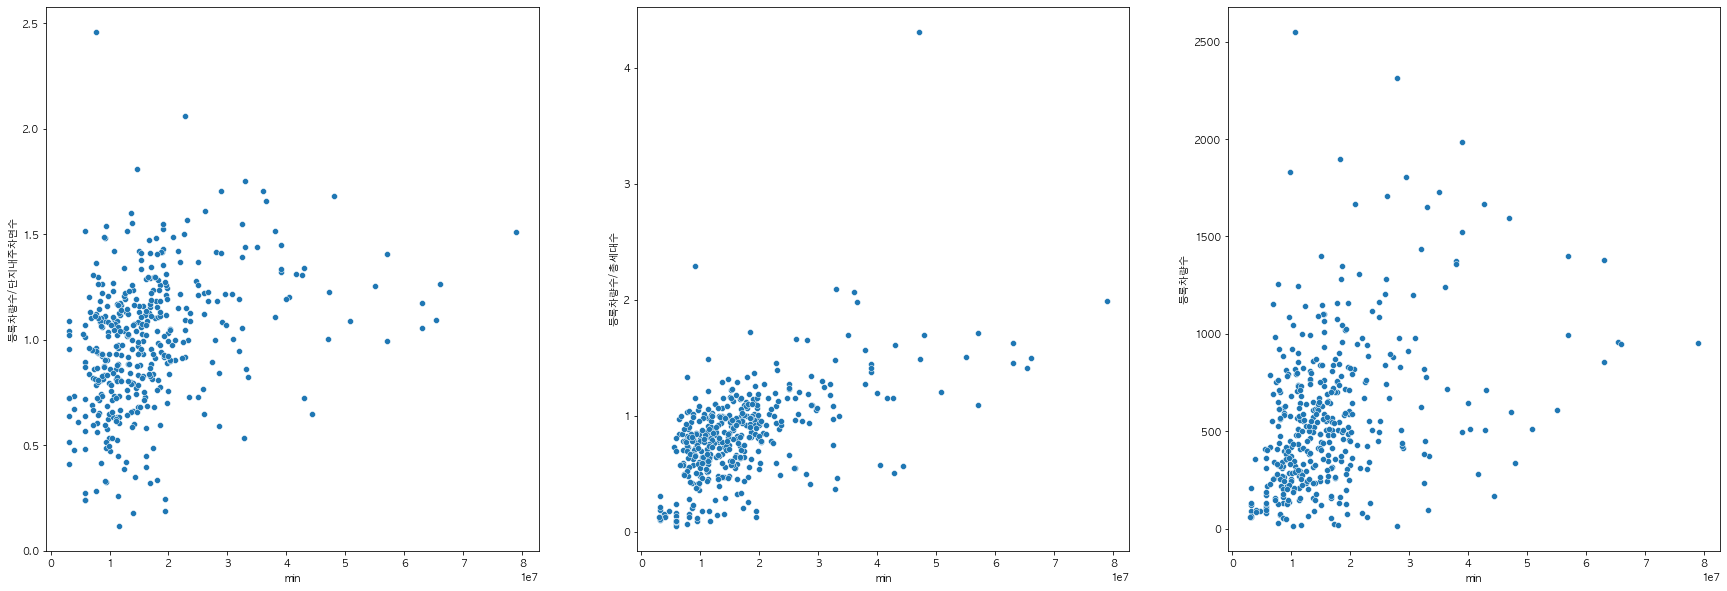

In [39]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
sns.scatterplot(x=apart_price1['min'],y=apart_price1['등록차량수/단지내주차면수'],ax=ax[0])
sns.scatterplot(x=apart_price1['min'],y=apart_price1['등록차량수/총세대수'],ax=ax[1])
sns.scatterplot(x=apart_price1['min'],y=apart_price1['등록차량수'],ax=ax[2])

In [40]:
apart_price1.corr()

,count,mean,std,min,25%,50%,75%,max,등록차량수/단지내주차면수,등록차량수/총세대수,등록차량수
count,1.0000,0.3160,0.2597,0.0872,0.2172,0.3129,0.3500,0.3527,-0.0238,0.1432,0.4257
mean,0.3160,1.0000,0.6012,0.7942,0.8873,0.9438,0.9697,0.8825,0.1944,0.5340,0.4195
std,0.2597,0.6012,1.0000,0.0626,0.2008,0.4481,0.7092,0.8830,-0.1005,0.1197,0.1763
min,0.0872,0.7942,0.0626,1.0000,0.9283,0.7724,0.6622,0.4879,0.3363,0.5697,0.3873
25%,0.2172,0.8873,0.2008,0.9283,1.0000,0.8648,0.7732,0.6148,0.2850,0.5789,0.3962
50%,0.3129,0.9438,0.4481,0.7724,0.8648,1.0000,0.9106,0.7413,0.2030,0.5188,0.3945
75%,0.3500,0.9697,0.7092,0.6622,0.7732,0.9106,1.0000,0.9064,0.1341,0.4737,0.3945
max,0.3527,0.8825,0.8830,0.4879,0.6148,0.7413,0.9064,1.0000,0.0645,0.3809,0.3500
등록차량수/단지내주차면수,-0.0238,0.1944,-0.1005,0.3363,0.2850,0.2030,0.1341,0.0645,1.0000,0.6904,0.3739
등록차량수/총세대수,0.1432,0.5340,0.1197,0.5697,0.5789,0.5188,0.4737,0.3809,0.6904,1.0000,0.5879


#### 상가

In [41]:
#상가
price0 = store.groupby('단지코드').describe()['임대료']
price1 = store.groupby('단지코드').describe()['임대보증금']

tmp = store.loc[store['지역'].isin(sub),:]
tmp_price0 = tmp.groupby('단지코드').describe()['임대료']
tmp_price1 = tmp.groupby('단지코드').describe()['임대보증금']

tmp1 = store.loc[store['지역'].isin(No_sub),:]
tmp1_price0 = tmp1.groupby('단지코드').describe()['임대료']
tmp1_price1 = tmp1.groupby('단지코드').describe()['임대보증금']

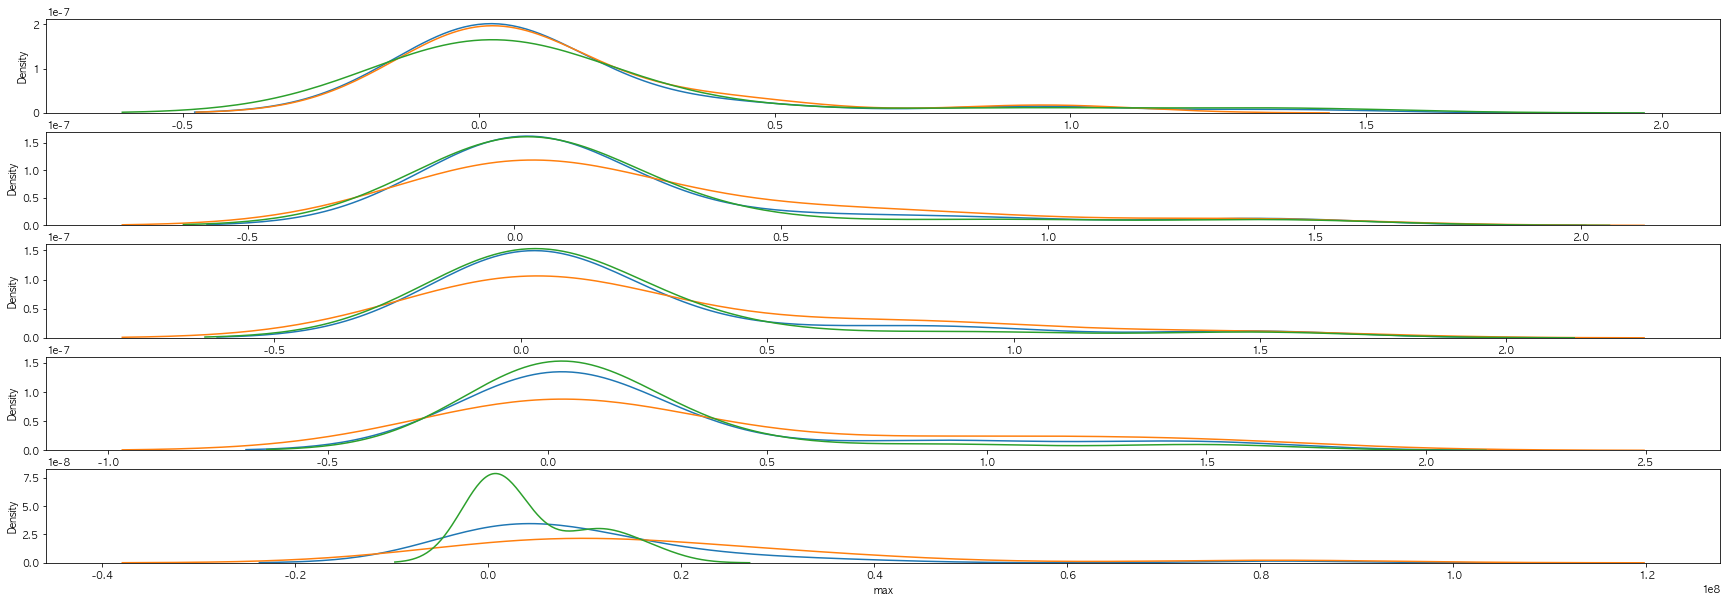

In [42]:
# 상가, 임대료
fig, ax = plt.subplots(5,1,figsize=(30,10))
for ind,i in enumerate(['min','25%','50%','75%','max']):
    sns.kdeplot(data=price0,x=i,ax=ax[ind]) #전체
    sns.kdeplot(data=tmp_price0,x=i,ax=ax[ind]) #sub
    sns.kdeplot(data=tmp1_price0,x=i,ax=ax[ind]) #nosub

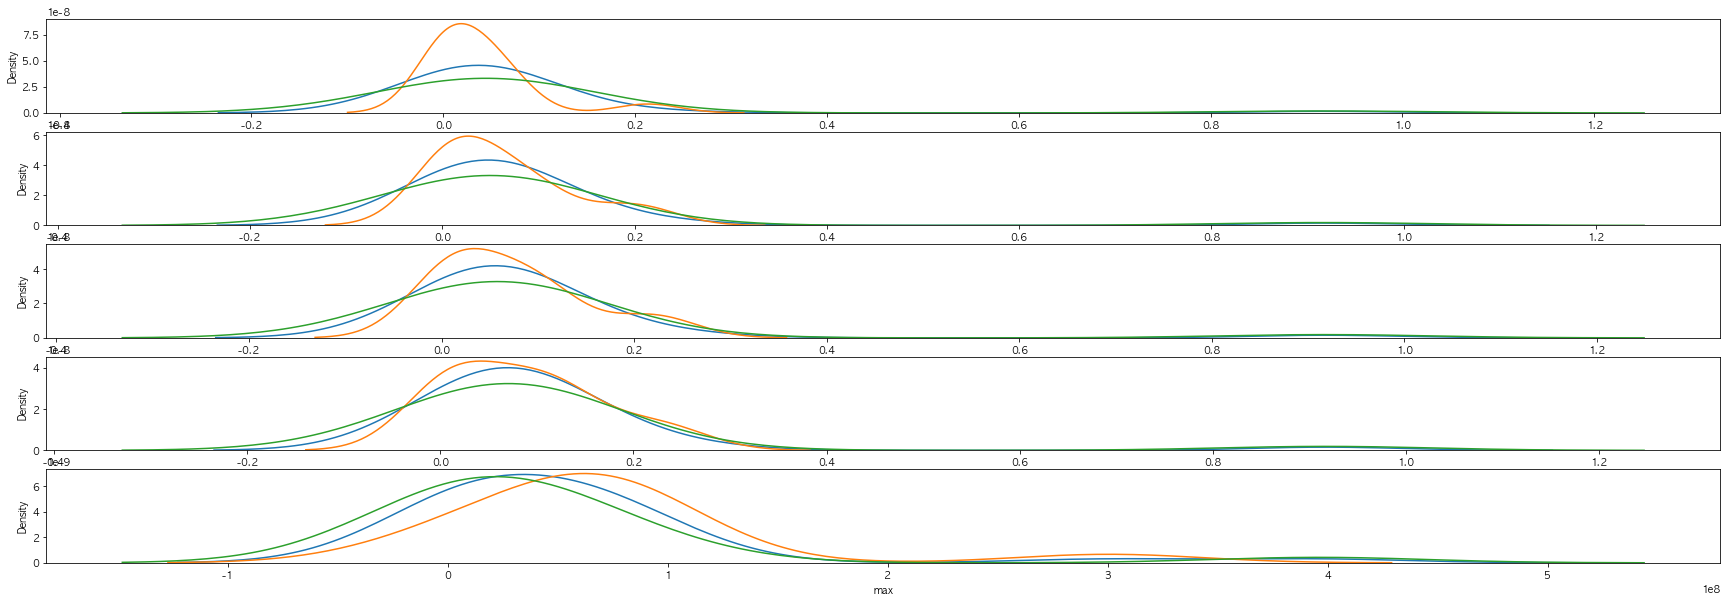

In [43]:
# 상가, 임대료
fig, ax = plt.subplots(5,1,figsize=(30,10))
for ind,i in enumerate(['min','25%','50%','75%','max']):
    sns.kdeplot(data=price1,x=i,ax=ax[ind]) #전체
    sns.kdeplot(data=tmp_price1,x=i,ax=ax[ind]) #sub
    sns.kdeplot(data=tmp1_price1,x=i,ax=ax[ind]) #nosub

- 상가는 no_sub, sub로 나누는 것이 무의미

### mean, sd 기준
#### 상가

In [44]:
#상가
price0 = store.groupby('단지코드').describe()['임대료'].reset_index()
price1 = store.groupby('단지코드').describe()['임대보증금'].reset_index()

tmp = store.loc[store['지역'].isin(sub),:]
tmp_price0 = tmp.groupby('단지코드').describe()['임대료']
tmp_price1 = tmp.groupby('단지코드').describe()['임대보증금']

tmp1 = store.loc[store['지역'].isin(No_sub),:]
tmp1_price0 = tmp1.groupby('단지코드').describe()['임대료']
tmp1_price1 = tmp1.groupby('단지코드').describe()['임대보증금']

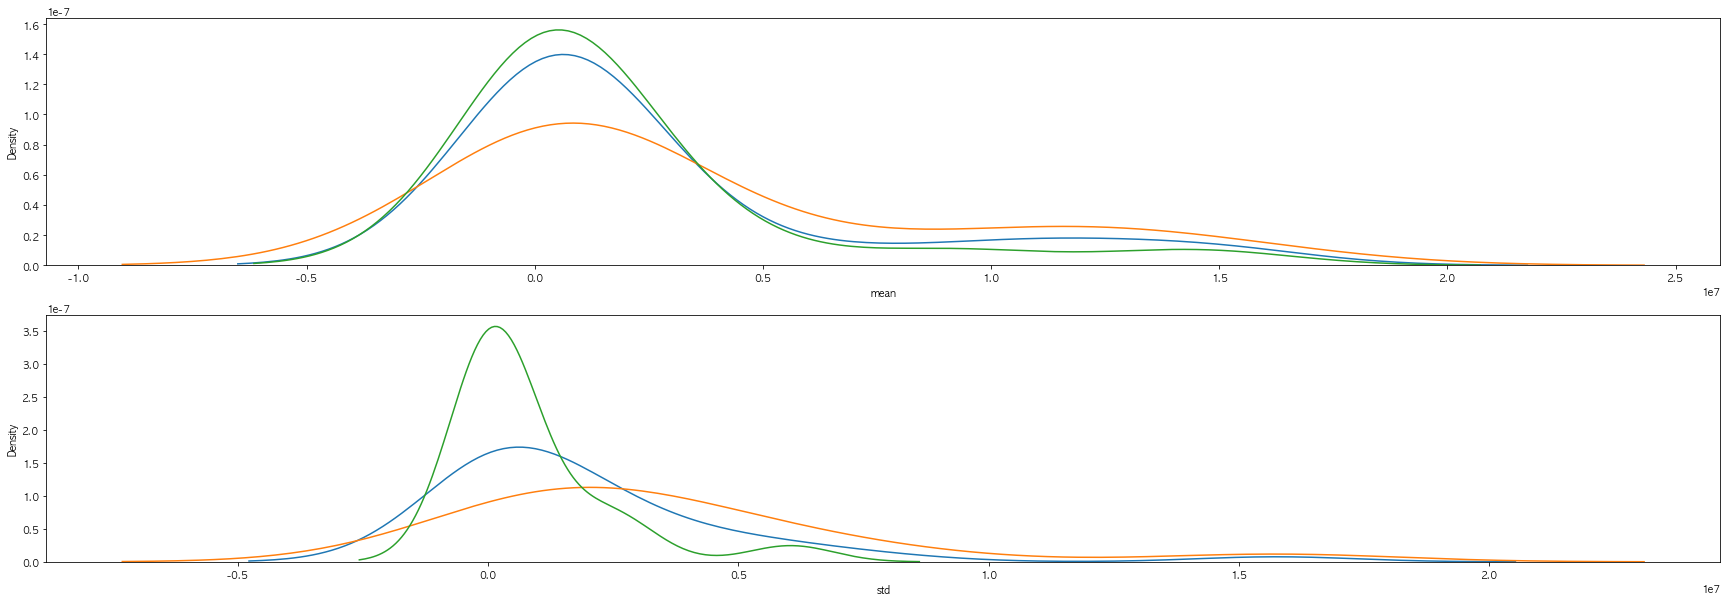

In [45]:
# 상가, 임대료
fig, ax = plt.subplots(2,1,figsize=(30,10))
for ind,i in enumerate(['mean','std']):
    sns.kdeplot(data=price0,x=i,ax=ax[ind]) #전체
    sns.kdeplot(data=tmp_price0,x=i,ax=ax[ind]) #sub
    sns.kdeplot(data=tmp1_price0,x=i,ax=ax[ind]) #nosub

- 평균값은 비슷하나 std에서 큰 차이가 남 $\rightarrow$ 유의미

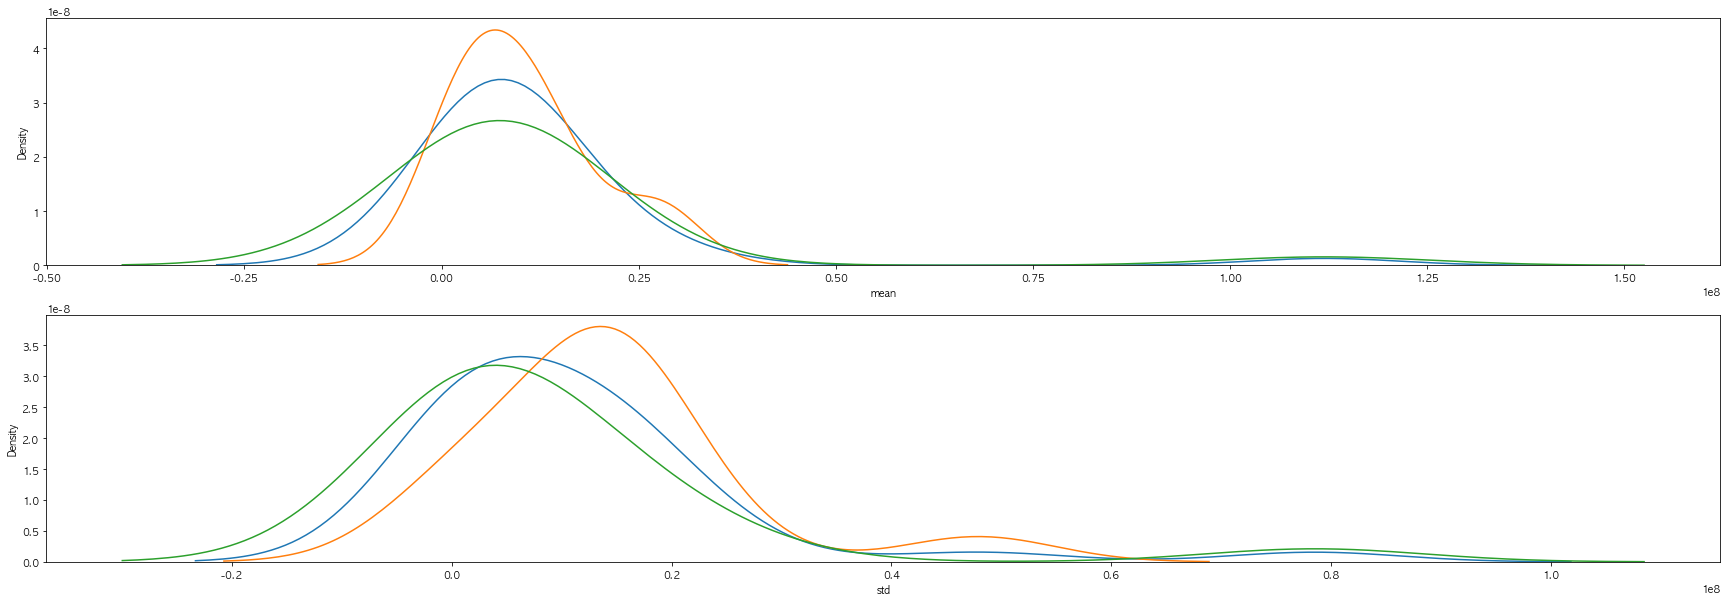

In [46]:
#상가,임대보증금
fig, ax = plt.subplots(2,1,figsize=(30,10))
for ind,i in enumerate(['mean','std']):
    sns.kdeplot(data=price1,x=i,ax=ax[ind]) #전체 
    sns.kdeplot(data=tmp_price1,x=i,ax=ax[ind]) #sub
    sns.kdeplot(data=tmp1_price1,x=i,ax=ax[ind]) #no_sub

- 상가 임대보증금도 평균은 비슷하나 std에서 차이가 남 $\rightarrow$ 유의미

In [47]:
y = store[['단지코드','등록차량수/단지내주차면수','등록차량수/총세대수','등록차량수']].drop_duplicates() #1788, 1610
store_price0 = pd.merge(price0,y,on='단지코드',how='inner') #임대료
store_price1 = pd.merge(price1,y,on='단지코드',how='inner') #임대보증금

In [48]:
store_price0.corr()

,count,mean,std,min,25%,50%,75%,max,등록차량수/단지내주차면수,등록차량수/총세대수,등록차량수
count,1.0000,0.0805,0.5689,-0.1667,-0.0307,-0.0125,0.0337,0.5588,-0.2422,-0.2777,0.1224
mean,0.0805,1.0000,0.4928,0.8467,0.9721,0.9834,0.9830,0.6527,0.1332,0.0073,0.2748
std,0.5689,0.4928,1.0000,0.0705,0.3194,0.3398,0.3888,0.9686,-0.0812,-0.1109,0.3547
min,-0.1667,0.8467,0.0705,1.0000,0.9378,0.9139,0.8340,0.2716,0.1296,0.0719,0.1301
25%,-0.0307,0.9721,0.3194,0.9378,1.0000,0.9947,0.9571,0.5108,0.1600,0.0535,0.2450
50%,-0.0125,0.9834,0.3398,0.9139,0.9947,1.0000,0.9795,0.5250,0.1664,0.0372,0.2422
75%,0.0337,0.9830,0.3888,0.8340,0.9571,0.9795,1.0000,0.5564,0.1554,0.0055,0.2326
max,0.5588,0.6527,0.9686,0.2716,0.5108,0.5250,0.5564,1.0000,-0.0396,-0.0832,0.3941
등록차량수/단지내주차면수,-0.2422,0.1332,-0.0812,0.1296,0.1600,0.1664,0.1554,-0.0396,1.0000,0.8855,0.7756
등록차량수/총세대수,-0.2777,0.0073,-0.1109,0.0719,0.0535,0.0372,0.0055,-0.0832,0.8855,1.0000,0.7926


In [49]:
store_price1.corr()

,count,mean,std,min,25%,50%,75%,max,등록차량수/단지내주차면수,등록차량수/총세대수,등록차량수
count,1.0000,0.0034,0.2232,-0.0957,-0.0410,-0.0193,0.0066,0.2752,-0.2422,-0.2777,0.1224
mean,0.0034,1.0000,0.8894,0.9696,0.9913,0.9948,0.9904,0.8638,-0.1154,-0.1322,-0.1373
std,0.2232,0.8894,1.0000,0.7733,0.8369,0.8561,0.8586,0.9845,-0.2068,-0.2395,-0.1488
min,-0.0957,0.9696,0.7733,1.0000,0.9872,0.9749,0.9585,0.7447,-0.0314,-0.0512,-0.1068
25%,-0.0410,0.9913,0.8369,0.9872,1.0000,0.9953,0.9844,0.8201,-0.0862,-0.0919,-0.1177
50%,-0.0193,0.9948,0.8561,0.9749,0.9953,1.0000,0.9935,0.8399,-0.0959,-0.1122,-0.1284
75%,0.0066,0.9904,0.8586,0.9585,0.9844,0.9935,1.0000,0.8429,-0.1196,-0.1332,-0.1489
max,0.2752,0.8638,0.9845,0.7447,0.8201,0.8399,0.8429,1.0000,-0.2147,-0.2340,-0.1342
등록차량수/단지내주차면수,-0.2422,-0.1154,-0.2068,-0.0314,-0.0862,-0.0959,-0.1196,-0.2147,1.0000,0.8855,0.7756
등록차량수/총세대수,-0.2777,-0.1322,-0.2395,-0.0512,-0.0919,-0.1122,-0.1332,-0.2340,0.8855,1.0000,0.7926


[결론]
- 그룹핑 유지(sub/no_sub)
- 아파트의 경우 quantile 값으로 1차원 merge
- 상가는 mean std값으로 1차원 merge

## 인구관련 변수

In [50]:
train.iloc[:,23:].corr()

,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,0~19세_비율,20~39세_비율,40~69세_비율,70세이상_비율,등록차량수/총세대수,등록차량수/단지내주차면수
총인구수,1.0000,0.5686,-0.1587,0.1887,-0.4405,-0.2586,0.2744,0.4646,0.3432,-0.3325,-0.5303,0.1712,-0.0271
세대당_인구,0.5686,1.0000,-0.3119,0.2731,-0.7305,-0.4260,0.2991,0.8661,0.3404,-0.5769,-0.7581,0.3764,0.1815
남/여비율,-0.1587,-0.3119,1.0000,0.1566,0.6561,0.8373,0.1264,-0.1557,0.1120,0.1136,-0.0215,0.0372,0.1023
남/여_0~19세,0.1887,0.2731,0.1566,1.0000,-0.2634,0.0930,0.2675,0.3729,0.4869,-0.5347,-0.4212,0.2842,0.1080
남/여_20~39세,-0.4405,-0.7305,0.6561,-0.2634,1.0000,0.6053,-0.2728,-0.6652,-0.3382,0.5737,0.5572,-0.2793,-0.0733
남/여_40~69세,-0.2586,-0.4260,0.8373,0.0930,0.6053,1.0000,0.0346,-0.2527,-0.1992,0.2014,0.2849,0.0137,0.0483
남/여_70세이상,0.2744,0.2991,0.1264,0.2675,-0.2728,0.0346,1.0000,0.1581,0.2494,-0.1717,-0.2548,0.3113,0.1864
0~19세_비율,0.4646,0.8661,-0.1557,0.3729,-0.6652,-0.2527,0.1581,1.0000,0.3941,-0.7659,-0.8060,0.3927,0.1886
20~39세_비율,0.3432,0.3404,0.1120,0.4869,-0.3382,-0.1992,0.2494,0.3941,1.0000,-0.7055,-0.7691,0.2013,0.0714
40~69세_비율,-0.3325,-0.5769,0.1136,-0.5347,0.5737,0.2014,-0.1717,-0.7659,-0.7055,1.0000,0.6780,-0.3376,-0.1399


## 공가수

<AxesSubplot:xlabel='공가수', ylabel='Density'>

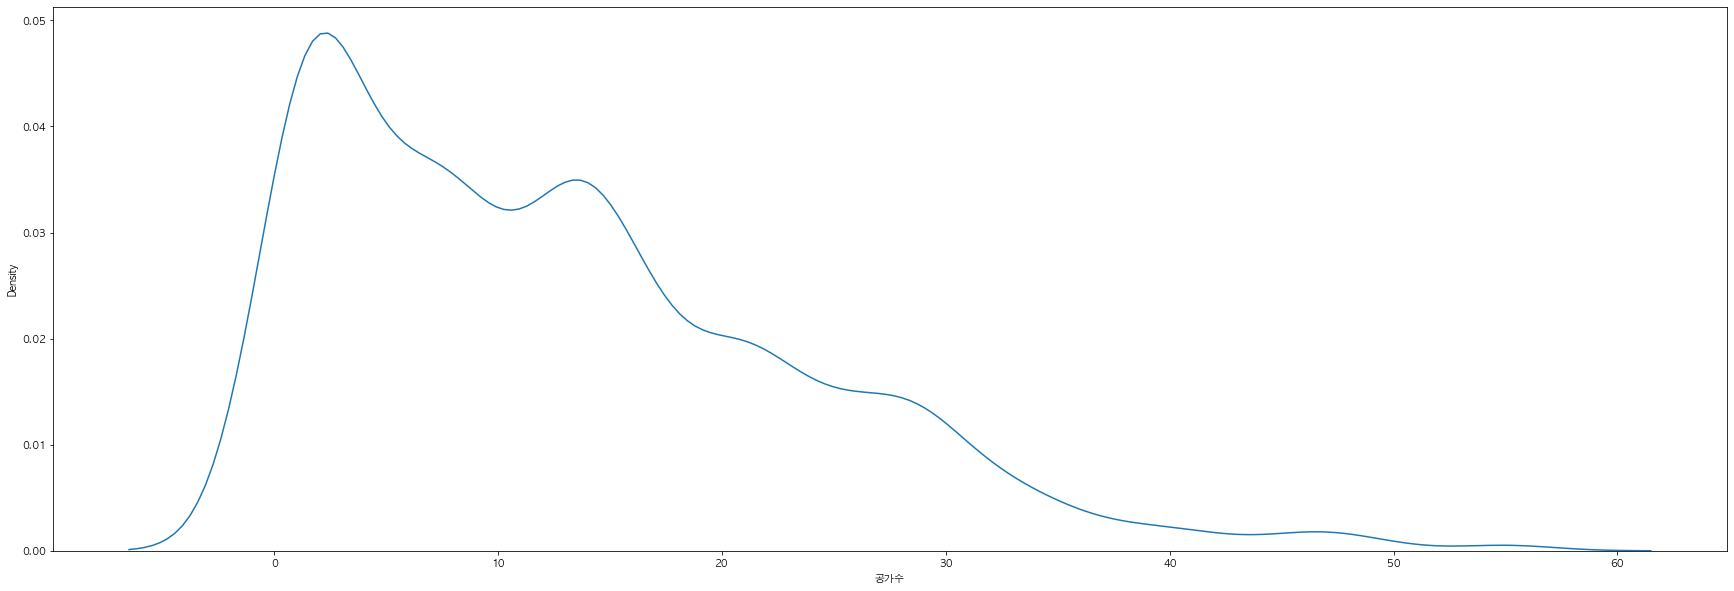

In [51]:
fig, ax = plt.subplots(figsize=(30,10))
sns.kdeplot(data=train,x='공가수')

In [52]:
tmp = train[['공가수','등록차량수','등록차량수/총세대수','등록차량수/단지내주차면수']]
tmp.corr()

,공가수,등록차량수,등록차량수/총세대수,등록차량수/단지내주차면수
공가수,1.0000,0.1185,0.0080,-0.1553
등록차량수,0.1185,1.0000,0.6654,0.4548
등록차량수/총세대수,0.0080,0.6654,1.0000,0.6875
등록차량수/단지내주차면수,-0.1553,0.4548,0.6875,1.0000


In [53]:
tmp = train.copy()
tmp['공가수_new'] = tmp.apply(lambda x : x['공가수']*x['세대당_인구'],axis=1)

In [55]:
tmp = tmp[['공가수_new','등록차량수','등록차량수/총세대수','등록차량수/단지내주차면수']]
tmp.corr()

,공가수_new,등록차량수,등록차량수/총세대수,등록차량수/단지내주차면수
공가수_new,1.0000,0.1676,0.0427,-0.1382
등록차량수,0.1676,1.0000,0.6654,0.4548
등록차량수/총세대수,0.0427,0.6654,1.0000,0.6875
등록차량수/단지내주차면수,-0.1382,0.4548,0.6875,1.0000
